In [ ]:
!pip install simpletransformers
!pip install transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [85]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [86]:
project_path='/content/drive/MyDrive/Colab Notebooks/fake-news/'

In [87]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# df=pd.read_csv(project_path+'kaggle_clean.csv')

# df=pd.read_csv(project_path+'kaggle_clean_only_true_false.csv').rename({'new_labels_1':'new_labels'},axis=1)

df=pd.read_csv(project_path+'kaggle_clean_only_true_false_balanced.csv').rename({'new_labels_1':'new_labels'},axis=1)


df.head()

,cleanText,new_labels
0,our health department our city and our county ...,1
1,significantly more people died of covid19 in t...,1
2,in covid19 crisis only 20 of african americans...,1
3,infection rates in allegany cattaraugus and ch...,1
4,since the week ending march 14 wisconsin actua...,1


In [88]:

X_train, X_test, y_train, y_test = train_test_split(df['cleanText'], df['new_labels'], test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42) # 


In [89]:
train_df = pd.DataFrame({'text':X_train.values,'labels':y_train.values})
val_df = pd.DataFrame({'text':X_val.values,'labels':y_val.values})
test_df = pd.DataFrame({'text':X_test.values,'labels':y_test.values})

In [90]:
print('Training sample: ' + str(len(train_df['text'])))
print('Validation sample: ' + str(len(val_df['text'])))
print('Testing sample: ' + str(len(test_df['text'])))

Training sample: 1408
Validation sample: 249
Testing sample: 415


In [91]:
import os
os.makedirs(project_path+'Transformer/output/',exist_ok=True)

In [92]:
model_type = "roberta"
model_name = "roberta-base"


train_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "use_cached_eval_features": True,
    "output_dir": project_path+"Transformer/output/"+model_type,
    "best_model_dir": project_path+"Transformer/output/"+model_type+"/best_model",
    "use_early_stopping": False,
    "early_stopping_delta": 0.0,
    "early_stopping_metric": "eval_loss",
    "early_stopping_metric_minimize" : True,
    "early_stopping_patience" : 2,
    "evaluate_during_training": True,
    "max_seq_length": 512,
    "num_train_epochs": 10,
    "evaluate_during_training_steps": 512,
    "wandb_project": "Fake News Fulltrain_1 RoBERTa",
    "wandb_kwargs": {"name": model_name},
    "save_model_every_epoch": False,
    "save_eval_checkpoints": False,
    "train_batch_size": 64,
    "eval_batch_size": 64,
    "evaluate_during_training_verbose" : True
}

In [93]:
# Below step requires https://wandb.ai/authorize account. Login use github is suggested.

In [94]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import sklearn

train_args["max_seq_length"] = 300
train_args["train_batch_size"] = 32
train_args["gradient_accumulation_steps"] = 2
train_args["evaluate_during_training"] = True
train_args["evaluate_during_training_steps"] = 1989
train_args["use_early_stopping"] = True


# Create a ClassificationModel
model = ClassificationModel(model_type, model_name, args=train_args)

# Train the model
history = model.train_model(train_df, eval_df=val_df,acc=sklearn.metrics.accuracy_score)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

  0%|          | 0/1408 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/44 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/44 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/44 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/44 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/44 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/44 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/44 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/44 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/44 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/44 [00:00<?, ?it/s]

In [95]:
result, model_outputs, wrong_predictions = model.eval_model(val_df)

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

Training loss,▇█▁▁
acc,▃▁▆▇▇▇▇█▇▇
auprc,▁▃▅▆▇█▇███
auroc,▁▄▆▇▇█████
eval_loss,▄▄▁▁▂▃▃▄█▇
fn,▆▂█▅▁▁▂▂▁▂
fp,▅█▁▂▃▃▂▂▃▂
global_step,▁▂▂▃▃▄▄▅▆▆▆▇▇█
lr,█▆▃▁
mcc,▁▁▄▆▇▇▇█▇▇
tn,▄▁█▇▆▆▇▇▆▇


In [96]:
predictions, raw_outputs = model.predict(test_df['text'])

  0%|          | 0/7 [00:00<?, ?it/s]

In [97]:
from sklearn.metrics import accuracy_score
print(accuracy_score(test_df['labels'],predictions))

0.5301204819277109


In [98]:
import os
os.makedirs(project_path+'Predictions',exist_ok=True)

In [99]:
import pickle
with open(project_path+'Predictions/pickle_Pred_Roberta_1_CC.pickle', 'wb') as f:
  pickle.dump((test_df['labels'],predictions),f)


In [100]:
import pickle
with open(project_path+'Predictions/pickle_Pred_Roberta_1_CC.pickle', 'rb') as f:
  y_true, y_pred = pickle.load(f)

In [101]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_true, y_pred))

0.5301204819277109


In [102]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.52      0.56      0.54       206
           1       0.54      0.50      0.52       209

    accuracy                           0.53       415
   macro avg       0.53      0.53      0.53       415
weighted avg       0.53      0.53      0.53       415



In [103]:
import matplotlib.pyplot as plt

In [104]:
history = history[1]

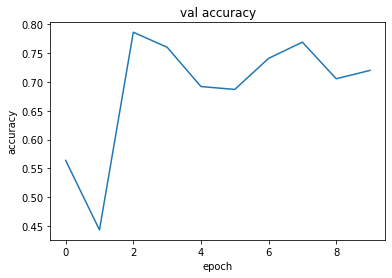

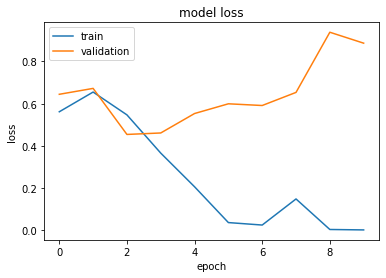

In [105]:
total_pos = np.array(history['tp'])+np.array(history['tn'])
total_neg = np.array(history['fp'])+np.array(history['fp'])
acc = total_pos/(total_pos+total_neg)

# plt.plot(history['acc'])
plt.plot(acc)
plt.title('val accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history['train_loss'])
plt.plot(history['eval_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

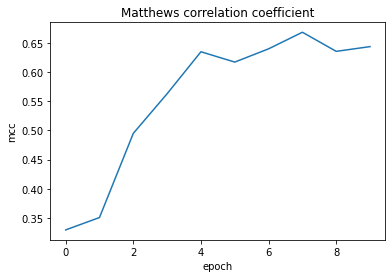

In [106]:
plt.plot(history['mcc'])
plt.title('Matthews correlation coefficient')
plt.ylabel('mcc')
plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [107]:
#Compute the Matthews correlation coefficient (MCC).

# The Matthews correlation coefficient is used in machine learning as a measure of the quality of binary and multiclass classifications. It takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction. The statistic is also known as the phi coefficient. [source: Wikipedia]